# Pan nn Text Classification Test
Trying to classify the age of an author based on a written conversation

## 1. Import libraries

In [ ]:
!pip install torchtext==0.4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import re
import os
import time

import torch
import torchtext

from torchtext.datasets import text_classification
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import nltk
import plotly.express as px
from nltk.stem import WordNetLemmatizer
import plotly.graph_objs as go
nltk.download('wordnet')
nltk.download('stopwords')

from collections import defaultdict, OrderedDict, Counter
import operator

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Load and preprocces the dataframe

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Language, speech and dialogue processing/Datasets/df_pan_train.csv') 

In [ ]:
df = df.drop(['Unnamed: 0', 'lang', 'id'], axis=1)

In [ ]:
df = df.groupby('gender').apply(lambda x: x.sample(frac=0.4))

In [ ]:
print(len(df))

160797


## 3. Create n_grams from the text (Optional)

In [ ]:
# lemmatizing function
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    return text

# remove stopwords
def remove_stopwords(text):
    stopword = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopword]
    return text
    
def tokenize(text):
    wrong_words = ["urllink", "nbsp"]
    tokens = [token for token in text.split(" ") if token != "" and token not in wrong_words]
    return tokens

def lowered(s):
    return s.lower()

def remove_nonalph(s):
      s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
      return s

def generate_ngrams(s, n):
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[s[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [ ]:
df["text"] = df["text"].apply(lowered).apply(remove_nonalph).apply(tokenize)

print(df['text'].iloc[0])
print(df['text'])

['canon', 'eos', '5d', 'mark', 'ii', '21', '1mp', 'full', 'frame', 'cmos', 'digital', 'slr', 'camera', 'it', 's', 'a', 'serious', 'camera', 'br', 'br', 'when', 'purchasing', 'a', 'digital', 'camera', 'you', 'should', 'be', 'sure', 'you', 'know', 'what', 'you', 'need', 'there', 'numerous', 'digital', 'cameras', 'that', 'come', 'with', 'a', 'variety', 'of', 'features', 'at', 'many', 'price', 'points', 'even', 'though', 'you', 'may', 'have', 'a', 'camera', 'that', 'is', 'excellent', 'for', 'the', 'newbie', 'it', 'may', 'not', 'take', 'great', 'pictures', 'however', 'for', 'the', 'professional', 'photographer', 'you', 'want', 'something', 'that', 'can', 'take', 'outstanding', 'pictures', 'br', 'br', 'if', 'you', 'have', 'the', 'money', 'to', 'invest', 'there', 's', 'a', 'camera', 'to', 'consider', 'the', 'newbie', 'wouldn', 't', 'normally', 'consider', 'the', 'canon', 'eos', '5d', 'because', 'it', 'is', 'priced', 'over', '2000', 'if', 'you', 'feel', 'it', 's', 'preposterous', 'to', 'spend'

In [ ]:
df.index = range(len(df))

In [ ]:
df

,age_group,gender,text
0,30s,female,"[canon, eos, 5d, mark, ii, 21, 1mp, full, fram..."
1,30s,female,"[sports, fans, will, love, moving, into, the, ..."
2,10s,female,"[looking, for, a, a, href, http, en, pan, netc..."
3,30s,female,"[nonetheless, these, days, there, are, a, broa..."
4,20s,female,"[amsec, gun, safes, are, nevertheless, made, w..."
...,...,...,...
160792,30s,male,"[thus, if, you, don, t, want, to, be, left, in..."
160793,30s,male,"[watch, beneath, the, darkness, online, downlo..."
160794,10s,male,"[span, class, textalign, textaligncenter, stro..."
160795,30s,male,"[the, strong, a, href, http, en, pan, netcom, ..."


## 4. To GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 5. Initialising Neural Network

In [ ]:
class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

## 6. Classes preprocessing
Checking the amount of classes and mapping them each to a different unique number 

In [ ]:
class_choice = 'gender'
classdict = defaultdict(int)

for row in df[class_choice]:
  classdict[row] += 1
print(sorted(classdict))

### PROBLEM: ALS IK DIT WISSEL NAAR NORMAL SORT DAN IS DE UITKOMST INEENS ANDERS???
classdict = dict(sorted(classdict.items(), key=operator.itemgetter(1), reverse=True))
#classdict = dict(sorted(classdict.items()))
print('classdict:')
print(classdict)

#fig = go.Figure([go.Bar(x=('female', 'male'), y=[classdict['female'], classdict['male']])])
#fig.show()

['female', 'male']
classdict:
{'male': 81256, 'female': 79541}


In [ ]:
# class to number mapping
classlist = list(classdict.keys())
classmap = dict([(y,x) for x,y in enumerate(classlist)])
print('classmap:')
print(classmap)
print('amount of classes')
print(len(classdict))

classmap:
{'male': 0, 'female': 1}
amount of classes
2


## 7. Vocabulary dictionary
Making a dict of all the words in the dataset and mapping each unique word to a unique number

In [ ]:
vocabdict = defaultdict(int)   

for row in df['text']:
  for n_gram in row:
    n_gram = n_gram.lower()
    vocabdict[n_gram] += 1

vocabdict = dict(sorted(vocabdict.items(), key=operator.itemgetter(1), reverse=True))
print(vocabdict)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# WORD TO NUMBER MAPPING
l = list(vocabdict.keys())
wordmap = dict([(y,x) for x,y in enumerate(l)])
print(wordmap)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## 8. Mapping text column to numbers (tensor)

In [ ]:
df_copy = df.copy()

for i, text in enumerate(df['text']):
  newtext = []
  for word in text:
    word = word.lower()
    newtext.append(int(wordmap[word]))
  df['text'][i] = torch.tensor(newtext).to(torch.int64)

In [ ]:
train_dataset = []

for index, row in df.iterrows():
  clasn = classmap[row['gender']]
  train_dataset.append(tuple((clasn, row['text'])))

As you can see below the train dataset is now a list with tuples (age, text)

In [ ]:
print(train_dataset[0])

(1, tensor([  4318,  11896,  10766,   2388,   4005,   2015,  82495,    410,   1964,
         17092,    702,   8339,    968,     13,     34,      1,   1142,    968,
             3,      3,     52,    975,      1,    702,    968,      6,     91,
            14,    163,      6,    113,     64,      6,     80,     48,    292,
           702,   1989,      9,    203,     16,      1,    435,      4,    478,
            45,     85,    232,    694,     81,    287,      6,     70,     23,
             1,    968,      9,      7,    269,     11,      0,   6578,     13,
            70,     33,    107,    118,   1332,    193,     11,      0,    392,
          2741,      6,     90,    240,      9,     19,    107,   1957,   1332,
             3,      3,     35,      6,     23,      0,    164,      2,   1232,
            48,     34,      1,    968,      2,    298,      0,   6578,   2353,
            60,    625,    298,      0,   4318,  11896,  10766,    105,     13,
             7,   1131,    150,   38

## 9. Run neural network

In [ ]:
vocab = len(vocabdict)
embed_dim = 32
n_classes = len(classdict)
BATCH_SIZE = 16
model = TextSentiment(vocab, embed_dim, n_classes).to(device)

In [ ]:
def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

### 9.1 Confusion *matrix*

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# confusion matrix plot function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Language, speech and dialogue processing/gender_PAN_nn_confusion_matrix.png')
    

In [ ]:
def train_func(sub_train_):

    # Train the model
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True,
                      collate_fn=generate_batch)
    for i, (text, offsets, cls) in enumerate(data):
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = model(text, offsets)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()

    # Adjust the learning rate
    scheduler.step()

    return train_loss / len(sub_train_), train_acc / len(sub_train_)

def test(data_, last_epoch=False):
    loss = 0
    acc = 0
    predictions = []
    labels = []
    inv_map = {v: k for k, v in classmap.items()}
    data = DataLoader(data_, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()
        pred = output.argmax(1).to('cpu')
        label = cls.to('cpu')
        predictions.extend(pred)
        labels.extend(label)
        
    if last_epoch == False:
      return loss / len(data_), acc / len(data_)
    else:
      return predictions, labels

Epoch: 1
	Loss: 0.0535(train)	|	Acc: 51.2%(train)
	Loss: 0.0002(valid)	|	Acc: 51.0%(valid)
Epoch: 2
	Loss: 0.0498(train)	|	Acc: 52.7%(train)
	Loss: 0.0002(valid)	|	Acc: 57.4%(valid)
Epoch: 3
	Loss: 0.0476(train)	|	Acc: 53.7%(train)
	Loss: 0.0003(valid)	|	Acc: 49.2%(valid)
Epoch: 4
	Loss: 0.0459(train)	|	Acc: 54.8%(train)
	Loss: 0.0003(valid)	|	Acc: 49.8%(valid)
Epoch: 5
	Loss: 0.0446(train)	|	Acc: 55.9%(train)
	Loss: 0.0002(valid)	|	Acc: 51.1%(valid)
Epoch: 6
	Loss: 0.0437(train)	|	Acc: 56.7%(train)
	Loss: 0.0002(valid)	|	Acc: 51.0%(valid)
Epoch: 7
	Loss: 0.0428(train)	|	Acc: 57.8%(train)
	Loss: 0.0002(valid)	|	Acc: 52.8%(valid)
Epoch: 8
	Loss: 0.0422(train)	|	Acc: 58.6%(train)
	Loss: 0.0002(valid)	|	Acc: 52.1%(valid)
Epoch: 9
	Loss: 0.0416(train)	|	Acc: 59.3%(train)
	Loss: 0.0002(valid)	|	Acc: 57.2%(valid)
Epoch: 10
	Loss: 0.0411(train)	|	Acc: 60.0%(train)
	Loss: 0.0002(valid)	|	Acc: 58.6%(valid)
Epoch: 11
	Loss: 0.0406(train)	|	Acc: 60.8%(train)
	Loss: 0.0002(valid)	|	Acc: 54.0%(vali

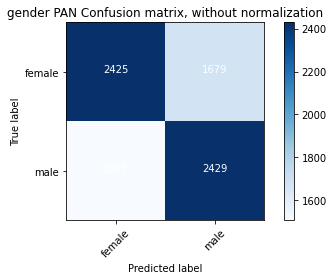

In [ ]:
N_EPOCHS = 30
min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=4.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_len = int(len(train_dataset) * 0.95)
sub_train_, sub_valid_ = \
    random_split(train_dataset, [train_len, len(train_dataset) - train_len])

start_time = time.time()
for epoch in range(N_EPOCHS):

  train_loss, train_acc = train_func(sub_train_)
  valid_loss, valid_acc = test(sub_valid_)

  print('Epoch: %d' %(epoch + 1))
  print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
  print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')
  if epoch == (N_EPOCHS-1):
    predictions, labels = test(sub_valid_, True)
    conf_matrix = confusion_matrix(np.array(labels), np.array(predictions), labels=[0, 1])
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    #plt.figure()
    plot_confusion_matrix(conf_matrix, classes=['female', 'male'], title='gender PAN Confusion matrix, without normalization')
total_time = int(time.time() - start_time)
print('Total time elapsed: %d seconds.' %(total_time))
torch.save(model.state_dict(), '/content/drive/MyDrive/Language, speech and dialogue processing/pan_state.pth')

Normalized confusion matrix
[[0.59 0.41]
 [0.38 0.62]]


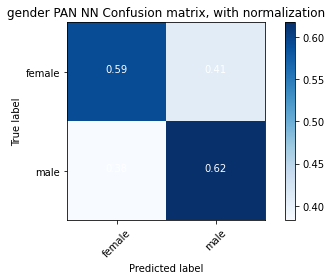

In [ ]:
plot_confusion_matrix(conf_matrix, classes=['female', 'male'], normalize=True, title='gender PAN NN Confusion matrix, with normalization')